In [1]:
# ============================================================================
# STEP 1: Setup & Imports
# ============================================================================
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd()))

import torch
import torch.nn.functional as F
import numpy as np
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd

# Import from your codebase
from CLAPWrapper import CLAPWrapper
from datasets.esc50 import ESC50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

Device: cpu


In [2]:
# ============================================================================
# STEP 2: Load Dataset & Model
# ============================================================================
print("\n" + "="*70)
print("LOADING ESC50 & CLAP MODEL")
print("="*70)

root_path = "./data"
dataset = ESC50(root=root_path, download=True)

# Prepare text prompts
prompt = 'this is the sound of '
text_labels = [prompt + x for x in dataset.classes]

# Load CLAP
wrapper = CLAPWrapper(version='2023', use_cuda=torch.cuda.is_available())
clap_model = wrapper.clap
clap_model.eval()

print(f"✅ Dataset: {len(dataset)} samples, {len(dataset.classes)} classes")
print(f"✅ CLAP model loaded")
print(f"   Audio encoder: {wrapper.args.audioenc_name}")
print(f"   Embedding dim: {wrapper.args.d_proj}")


LOADING ESC50 & CLAP MODEL
Loading audio files


2000it [00:00, 18317.82it/s]


✅ Dataset: 2000 samples, 50 classes
✅ CLAP model loaded
   Audio encoder: HTSAT
   Embedding dim: 1024


In [3]:
# ============================================================================
# STEP 3: Extract Attention Heads Architecture Info
# ============================================================================
print("\n" + "="*70)
print("ANALYZING HTSAT ARCHITECTURE")
print("="*70)

# Get audio encoder (HTSAT)
audio_encoder = clap_model.audio_encoder.base.htsat

# Inspect architecture
print(f"\n📐 HTSAT Architecture:")
print(f"   Number of layers: {audio_encoder.num_layers}")
print(f"   Depths per layer: {audio_encoder.depths}")
print(f"   Number of heads per layer: {audio_encoder.num_heads}")
print(f"   Embed dimensions: {audio_encoder.embed_dim}")
print(f"   Window size: {audio_encoder.window_size}")

# Calculate total number of attention heads
total_heads = 0
head_info = []
for layer_idx, (depth, n_heads) in enumerate(zip(audio_encoder.depths, audio_encoder.num_heads)):
    layer_heads = depth * n_heads
    total_heads += layer_heads
    head_info.append({
        'layer': layer_idx,
        'depth': depth,
        'n_heads': n_heads,
        'total_heads_in_layer': layer_heads
    })
    print(f"   Layer {layer_idx}: {depth} blocks × {n_heads} heads = {layer_heads} total heads")

print(f"\n   🎯 TOTAL ATTENTION HEADS: {total_heads}")

# Store for later
head_info_df = pd.DataFrame(head_info)


ANALYZING HTSAT ARCHITECTURE

📐 HTSAT Architecture:
   Number of layers: 4
   Depths per layer: [2, 2, 6, 2]
   Number of heads per layer: [4, 8, 16, 32]
   Embed dimensions: 96
   Window size: 8
   Layer 0: 2 blocks × 4 heads = 8 total heads
   Layer 1: 2 blocks × 8 heads = 16 total heads
   Layer 2: 6 blocks × 16 heads = 96 total heads
   Layer 3: 2 blocks × 32 heads = 64 total heads

   🎯 TOTAL ATTENTION HEADS: 184


In [4]:
# ============================================================================
# STEP 4: Hook Registration - Extract Head Representations
# ============================================================================
print("\n" + "="*70)
print("SETTING UP ATTENTION HEAD EXTRACTION")
print("="*70)

class HeadExtractor:
    """Extract attention head outputs from HTSAT"""
    
    def __init__(self, model):
        self.model = model
        self.head_outputs = defaultdict(list)
        self.attention_weights = defaultdict(list)
        self.hooks = []
        
    def _get_hook(self, layer_idx, block_idx):
        """Create hook function for specific layer and block"""
        def hook(module, input, output):
            # output is tuple: (x, attn)
            # x shape: [B, N, C] where N = num_patches
            # attn shape: [B, num_heads, N, N]
            x, attn = output
            
            # Store the output AFTER attention (this is what goes to residual)
            key = f"L{layer_idx}_B{block_idx}"
            self.head_outputs[key].append(x.detach().cpu())
            self.attention_weights[key].append(attn.detach().cpu())
            
        return hook
    
    def register_hooks(self):
        """Register forward hooks on all SwinTransformerBlocks"""
        print("\n📍 Registering hooks...")
        
        for layer_idx, layer in enumerate(self.model.layers):
            for block_idx, block in enumerate(layer.blocks):
                hook = block.register_forward_hook(
                    self._get_hook(layer_idx, block_idx)
                )
                self.hooks.append(hook)
                
        print(f"   ✅ Registered {len(self.hooks)} hooks")
        
    def remove_hooks(self):
        """Remove all hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        
    def clear_cache(self):
        """Clear stored outputs"""
        self.head_outputs.clear()
        self.attention_weights.clear()
        
    def get_head_representations(self):
        """Return collected head representations"""
        return self.head_outputs, self.attention_weights

# Initialize extractor
extractor = HeadExtractor(audio_encoder)
extractor.register_hooks()


SETTING UP ATTENTION HEAD EXTRACTION

📍 Registering hooks...
   ✅ Registered 12 hooks


In [5]:
# ============================================================================
# STEP 5: Extract Head Representations on Sample Data
# ============================================================================
print("\n" + "="*70)
print("EXTRACTING HEAD REPRESENTATIONS")
print("="*70)

# Use subset for initial analysis
n_samples = 200  # Stratified across classes
samples_per_class = n_samples // len(dataset.classes)

print(f"\n📊 Extracting from {n_samples} samples ({samples_per_class} per class)...")

# Collect audio samples stratified by class
class_samples = defaultdict(list)
for idx in range(len(dataset)):
    audio_path, class_name, one_hot_target = dataset[idx]
    class_idx = torch.argmax(one_hot_target).item()
    print(f"Sample {idx}: {class_name} (class {class_idx}) -> {audio_path}")
    
    if len(class_samples[class_idx]) < samples_per_class:
        class_samples[class_idx].append((audio_path, class_idx))
    
    if all(len(samples) >= samples_per_class for samples in class_samples.values()):
        break

# Flatten to list
sample_list = []
for class_idx, samples in class_samples.items():
    sample_list.extend(samples)

print(f"   Collected {len(sample_list)} samples")

# Extract representations
extractor.clear_cache()
all_labels = []

for audio_path, label in tqdm(sample_list, desc="Extracting heads"):
    # Preprocess audio
    audio_tensor = wrapper.load_audio_into_tensor(
        audio_path, wrapper.args.duration, resample=True
    )
    audio_tensor = audio_tensor.reshape(1, -1).to(device)
    
    # Forward pass (hooks will capture head outputs)
    with torch.no_grad():
        _ = audio_encoder(audio_tensor)
    
    all_labels.append(label)

# Get collected representations
head_outputs, attention_weights = extractor.get_head_representations()

print(f"\n✅ Extracted representations from {len(head_outputs)} blocks")
print(f"   Example block shape: {head_outputs[list(head_outputs.keys())[0]][0].shape}")
print(f"   Labels shape: {len(all_labels)}")


EXTRACTING HEAD REPRESENTATIONS

📊 Extracting from 200 samples (4 per class)...
Sample 0: dog (class 18) -> ./data/ESC-50-master/audio/1-100032-A-0.wav
Sample 1: chirping birds (class 7) -> ./data/ESC-50-master/audio/1-100038-A-14.wav
Sample 2: vacuum cleaner (class 46) -> ./data/ESC-50-master/audio/1-100210-A-36.wav
Sample 3: vacuum cleaner (class 46) -> ./data/ESC-50-master/audio/1-100210-B-36.wav
Sample 4: thunderstorm (class 43) -> ./data/ESC-50-master/audio/1-101296-A-19.wav
Sample 5: thunderstorm (class 43) -> ./data/ESC-50-master/audio/1-101296-B-19.wav
Sample 6: door wood knock (class 20) -> ./data/ESC-50-master/audio/1-101336-A-30.wav
Sample 7: can opening (class 3) -> ./data/ESC-50-master/audio/1-101404-A-34.wav
Sample 8: crow (class 16) -> ./data/ESC-50-master/audio/1-103298-A-9.wav
Sample 9: door wood knock (class 20) -> ./data/ESC-50-master/audio/1-103995-A-30.wav
Sample 10: door wood knock (class 20) -> ./data/ESC-50-master/audio/1-103999-A-30.wav
Sample 11: clapping (cl

Extracting heads:   0%|          | 0/200 [00:00<?, ?it/s]


✅ Extracted representations from 12 blocks
   Example block shape: torch.Size([1, 4096, 96])
   Labels shape: 200


In [6]:
# ============================================================================
# STEP 6: Analyze Intrinsic Dimensionality (Linear - PCA)
# ============================================================================
print("\n" + "="*70)
print("ANALYZING INTRINSIC DIMENSIONALITY (PCA)")
print("="*70)

def compute_linear_id(representations, variance_threshold=0.99):
    """
    Compute linear intrinsic dimensionality using PCA
    Returns number of components needed to explain variance_threshold
    """
    # representations: list of tensors [B, N, C]
    # We need to concatenate across batch and average pool spatial dims
    
    # Stack all samples
    stacked = torch.cat(representations, dim=0)  # [total_samples, N, C]
    
    # Average pool spatial dimension (like mean pooling)
    pooled = stacked.mean(dim=1)  # [total_samples, C]
    
    # Convert to numpy
    X = pooled.numpy()
    
    # Fit PCA
    pca = PCA(n_components=min(X.shape))
    pca.fit(X)
    
    # Find number of components for threshold
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumsum >= variance_threshold) + 1
    
    # Get first PC explained variance
    evr_first = pca.explained_variance_ratio_[0]
    
    return {
        'n_components_99': n_components,
        'total_variance': cumsum[-1],
        'evr_first_pc': evr_first,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'pca': pca
    }

# Compute for each block
id_results = {}
pca_objects = {}

print("\n🔬 Computing PCA for each block...")
for block_key in tqdm(sorted(head_outputs.keys())):
    representations = head_outputs[block_key]
    result = compute_linear_id(representations)
    id_results[block_key] = result
    pca_objects[block_key] = result['pca']

print(f"\n✅ PCA computed for {len(id_results)} blocks")


ANALYZING INTRINSIC DIMENSIONALITY (PCA)

🔬 Computing PCA for each block...


  0%|          | 0/12 [00:00<?, ?it/s]


✅ PCA computed for 12 blocks



VISUALIZING DIMENSIONALITY ANALYSIS


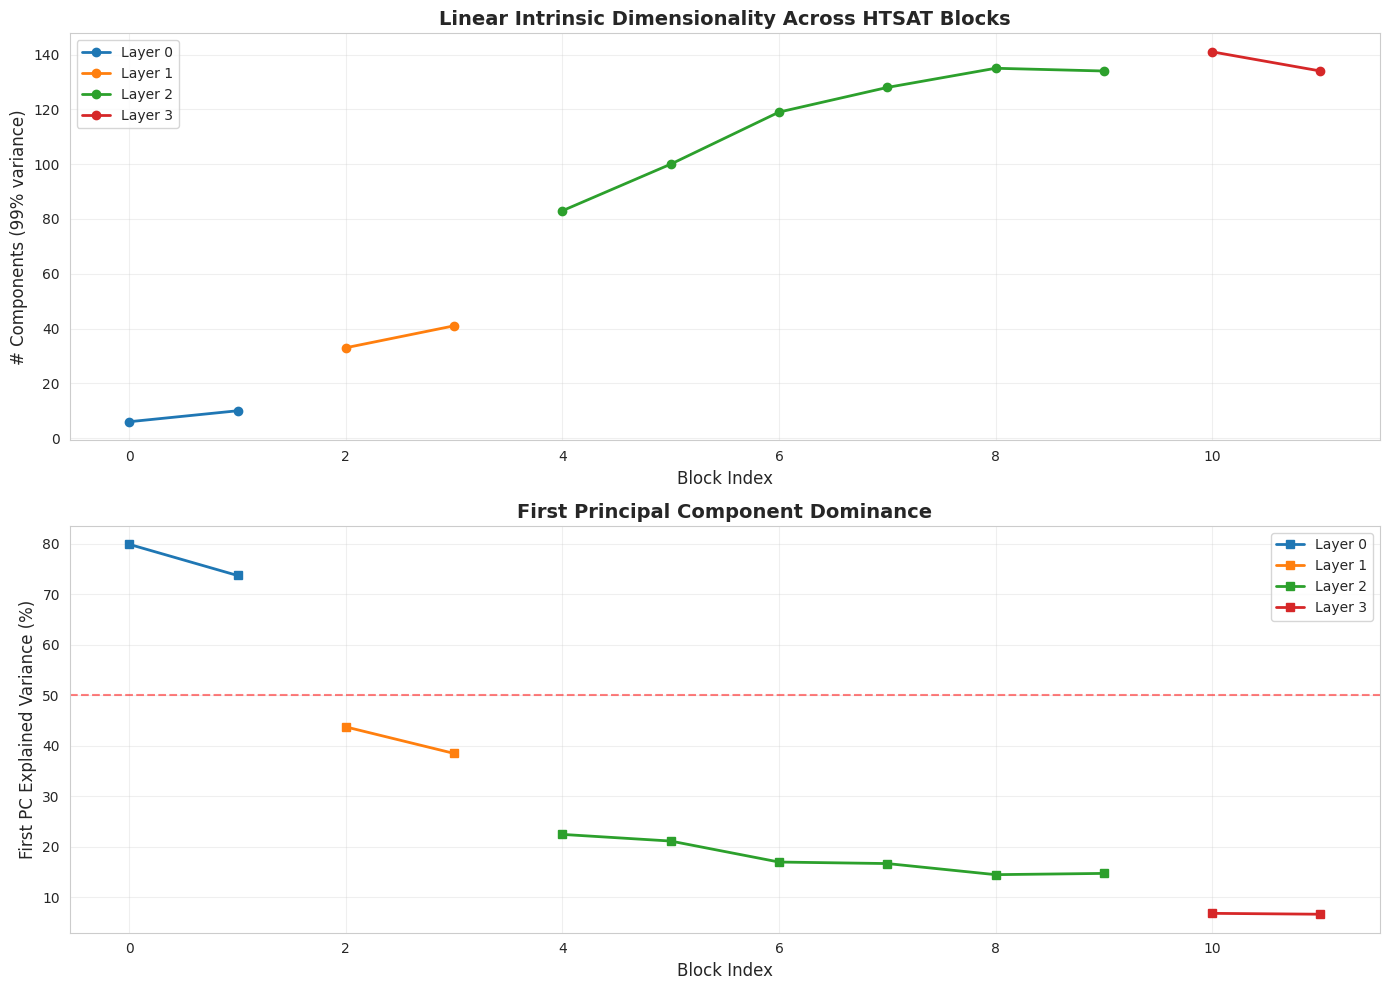


📊 Summary Statistics:
   Mean components (99% var): 88.7
   Mean first PC variance: 29.6%
   Early layers (L0) first PC: 76.8%
   Late layers (L3) first PC: 6.7%


In [7]:
# ============================================================================
# STEP 7: Visualize Intrinsic Dimensionality
# ============================================================================
print("\n" + "="*70)
print("VISUALIZING DIMENSIONALITY ANALYSIS")
print("="*70)

# Prepare data for plotting
plot_data = []
for block_key, result in id_results.items():
    layer_idx = int(block_key.split('_')[0][1:])
    block_idx = int(block_key.split('_')[1][1:])
    
    plot_data.append({
        'block': block_key,
        'layer': layer_idx,
        'block_idx': block_idx,
        'n_components_99': result['n_components_99'],
        'evr_first_pc': result['evr_first_pc']
    })

plot_df = pd.DataFrame(plot_data)

# Plot 1: Number of components across blocks
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Subplot 1: Linear ID (components needed for 99% variance)
ax1 = axes[0]
for layer in sorted(plot_df['layer'].unique()):
    layer_data = plot_df[plot_df['layer'] == layer]
    ax1.plot(layer_data.index, layer_data['n_components_99'], 
             marker='o', label=f'Layer {layer}', linewidth=2)

ax1.set_xlabel('Block Index', fontsize=12)
ax1.set_ylabel('# Components (99% variance)', fontsize=12)
ax1.set_title('Linear Intrinsic Dimensionality Across HTSAT Blocks', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Subplot 2: First PC Explained Variance Ratio
ax2 = axes[1]
for layer in sorted(plot_df['layer'].unique()):
    layer_data = plot_df[plot_df['layer'] == layer]
    ax2.plot(layer_data.index, layer_data['evr_first_pc'] * 100, 
             marker='s', label=f'Layer {layer}', linewidth=2)

ax2.set_xlabel('Block Index', fontsize=12)
ax2.set_ylabel('First PC Explained Variance (%)', fontsize=12)
ax2.set_title('First Principal Component Dominance', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50% threshold')

plt.tight_layout()
plt.savefig('dimensionality_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Summary Statistics:")
print(f"   Mean components (99% var): {plot_df['n_components_99'].mean():.1f}")
print(f"   Mean first PC variance: {plot_df['evr_first_pc'].mean()*100:.1f}%")
print(f"   Early layers (L0) first PC: {plot_df[plot_df['layer']==0]['evr_first_pc'].mean()*100:.1f}%")
print(f"   Late layers (L{plot_df['layer'].max()}) first PC: {plot_df[plot_df['layer']==plot_df['layer'].max()]['evr_first_pc'].mean()*100:.1f}%")

In [ ]:
# ============================================================
# STEP 8: Analyze Head Specialization with Text Prompts (fixed)
# ============================================================

print("\n" + "="*70)
print("ANALYZING HEAD SPECIALIZATION (FIXED WITH PROJECTION)")
print("="*70)

# Get text embeddings for all class labels (these are already in d_proj space)
text_embeddings = wrapper.get_text_embeddings(text_labels)  # torch.Tensor [N_classes, d_proj]
text_embeddings = text_embeddings / (text_embeddings.norm(dim=-1, keepdim=True) + 1e-8)

print(f"\n📝 Text embeddings shape: {text_embeddings.shape} (d_proj={text_embeddings.shape[1]})")

# Last layer index (keep audio_encoder as the HTSAT object)
last_layer_idx = audio_encoder.num_layers - 1
last_layer_blocks = [k for k in head_outputs.keys() if k.startswith(f'L{last_layer_idx}')]

print(f"\n🎯 Analyzing {len(last_layer_blocks)} blocks from last layer (Layer {last_layer_idx})...")

specialization_scores = {}

# Determine device for projection (if exists) and text embeddings
proj_device = None
try:
    proj_device = next(wrapper.clap.audio_encoder.projection.parameters()).device
except Exception:
    proj_device = torch.device('cpu')

# Ensure text embeddings are on same device as projection for matmul
text_embeddings_proj_device = text_embeddings.to(proj_device)

for block_key in tqdm(sorted(last_layer_blocks), desc="Computing specialization"):
    representations = head_outputs[block_key]             # list of tensors [B, N, C_in]
    
    # Stack and pool
    stacked = torch.cat(representations, dim=0)           # [total_samples, N, C_in]
    pooled = stacked.mean(dim=1)                          # [total_samples, C_in]
    
    # Get first PC direction (from sklearn PCA)
    pca = pca_objects[block_key]
    pc1_direction = torch.from_numpy(pca.components_[0]).float()  # [C_in]
    
    # Make sure pc1_direction on CPU (pooled likely on CPU)
    # Project representations onto PC1 scalar
    pc1_direction = pc1_direction.to(pooled.device)
    pc1_projections = pooled @ pc1_direction                # [total_samples]
    
    # Reconstruct PC1-based vector in original audio feature space
    pc1_repr = pc1_projections.unsqueeze(1) * pc1_direction.unsqueeze(0)  # [total_samples, C_in]
    
    # Now apply the CLAP audio_projection to map to d_proj
    # Use helper wrapper.project_audio_representation if you added it,
    # otherwise call projection directly:
    try:
        # prefer wrapper helper if present
        pc1_proj = wrapper.project_audio_representation(pc1_repr)
    except Exception:
        # fallback: use projection layer directly
        proj_layer = wrapper.clap.audio_encoder.projection
        device = next(proj_layer.parameters()).device
        pc1_proj = proj_layer(pc1_repr.to(device))

    # Normalize projected representations
    pc1_proj = pc1_proj / (pc1_proj.norm(dim=-1, keepdim=True) + 1e-8)  # [total_samples, d_proj]

    # Ensure text embeddings on same device
    text_embs = text_embeddings_proj_device  # [N_classes, d_proj]

    # Compute similarity (N_samples x N_classes)
    similarity = pc1_proj @ text_embs.T  # matmul ok: [N_samples, d_proj] x [d_proj, N_classes] -> [N_samples, N_classes]

    # Move similarity to CPU / numpy for class-wise aggregation
    similarity_np = similarity.cpu().numpy()

    # For each class, compute mean similarity with samples of that class
    class_specific_sim = []
    for class_idx in range(len(dataset.classes)):
        class_mask = np.array(all_labels) == class_idx      # all_labels must align with samples order
        if class_mask.sum() > 0:
            class_sim = similarity_np[class_mask, class_idx].mean()
            class_specific_sim.append(float(class_sim))
        else:
            class_specific_sim.append(0.0)

    specialization_scores[block_key] = {
        'class_similarities': class_specific_sim,
        'mean_specialization': float(np.mean(class_specific_sim)),
        'max_specialization': float(np.max(class_specific_sim)),
        'best_class_idx': int(np.argmax(class_specific_sim))
    }

print(f"\n✅ Specialization computed for {len(specialization_scores)} blocks")



ANALYZING HEAD SPECIALIZATION

📝 Text embeddings shape: torch.Size([50, 1024])

🎯 Analyzing 2 blocks from last layer (Layer 3)...


Computing specialization:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (200x768 and 1024x50)